# TP ANALYSE DE SENTIMENT - PARTIE RESTAURANTS

Le jeu de données Restaurant_Train est composé de 3041 phrases en anglais 
tirées des critiques de restaurants.
Les valeurs possibles pour la polarité des aspects sont : “positive”, “negative”, “conflict”, “neutral”. 
Les valeurs possibles des categories sont : “food”, “service”, “price”, “ambience”, “anecdotes/miscellaneous”.

Le jeu de données Laptop_Train est composé de 3045 phrases anglaises extraites 
des commentaires des clients sur les ordinateurs portables. Des annotateurs humains 
expérimentés ont annoté les termes d'aspect des phrases et leurs polarités

## Première tâche : analyse des sentiments du jeux de données sur les restaurants 
On commence par télécharger les fichiers suivants qui se trouvent dans le repertoire TPSA/datasets sur Moodle :
* Restaurants_Train.xml (ensemble d'entrainement - contient les valeurs de polarité)
* Restaurants_Test_NoLabels.xml (ensemble de test - sans les polarités)
* Restaurants_Test_Gold.xml (ensemble de validation - sans les polarités)
--------------------------------------------------------------------------------------------------------------------------

     Objectif 1: calculer la polarité des mots dans les deux jeux de données à l’aide d’un lexicon de sentiment. 
Avant d’utiliser le lexicon pour calculer la polarité des mots contenus dans les phrases dans les deux jeux de données, il est nécessaire de faire un pré-traitement des phases (negation, tokenizer, PoS tagger, et NER). 
* Vous devez implémenter un système d'extraction d'informations simple. Le texte brut de chaque phrase est subdivisée en mots à l'aide d'un tokenizer. 
* Ensuite, chaque phrase est étiquetée avec des balises de partie de discours (PoS tagger), ~~ce qui s'avérera très utile à l'étape suivante, la détection d'entités nommées (NER).~~

**Remarque**
- La NER n'est pas nécessaire ici, car nous avons déjà les terms à identifier dans le Train et le test. 
- Les étapes à suivres sont alors les suivantes :

* **Chargement**
    * Charger les données depuis les fichiers en récupérant le terme et toutes ses informations (le term lui meme, son emplacement, sa phrase, sa polarité)
    * Transformer les phrases en token avec PosTag afin de les ajouter dans notre dataframe et d'avoir des infos supplémentaires sur la structure de la phrase.
* **Sentiments**
    * Une  fois  que  le  pré-traitement  des  phrases  est  terminé,  vous  pouvez  télécharger  le lexicon SentiWordNet (https://github.com/aesuli/SentiWordNet).
    * Apres le téléchargement, vous devez identifier la polarité associé a chaque mot dans les phrases contenues dans les jeux de données (fichiers Train et Test, 4 fichiers à traiter) en utilisant le lexicon SentiWordNet:
     - pour chaque mot (que vous avez identifié avec le tokenizer, stop words exclues) vous cherchez si le mot est present dans le lexicon. 
     - S’il est present, alors vous assignez à ce mot la polarité positive/negative associée au mot dans le lexicon ansi que le degré associé.A vous de choisir le format (balises) pour stocker ces informations, qui vous seront utiles après. 
     - S’il n’est pas present, vous pouvez passer au mot suivant.
     - Enfin,  vous  devez  générer  une  visualisation  des  données  à  travers  des  graphiques  pour montrer combien de mots ont une polarité positive / negative dans chaque fichier.
-----------------------------------------------------------------------------------------------------------------------------------------

In [1]:
#SPACY
import en_core_web_sm   # téléchargement ici : https://spacy.io/models/en

#NLTK
import nltk
from nltk import ne_chunk, pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('sentiwordnet')

#AUTRES LIBRAIRIES
import pandas as pd
import xml.etree.ElementTree as et 
import matplotlib.pyplot as plt

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\belka\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


* ### **CHARGEMENT**
------------------------------------------------------------

Les valeurs possibles pour la polarité des aspects sont : “positive”, “negative”, “conflict”, “neutral”. 
Les valeurs possibles des categories sont : “food”, “service”, “price”, “ambience”, “anecdotes/miscellaneous”.
* Nous ne nous intéressons qu'au polarité des terms

#### <font color='red'>1ère Méthode : On fait un dataframe avec une phase par ligne</font>

In [5]:
xtree = et.parse("Restaurants_Train.xml")
xroot = xtree.getroot()
comments_restaurants = []
attributes_restaurants = []

for sentence in xroot.findall('sentence'):
    attribute_restaurant = []
    idi = sentence.get('id')
    text = sentence.find('text').text
    comments_restaurants.append([idi,text])
    #print(idi, text)
    for neighbor in sentence.iter('aspectTerm'):
        #print(neighbor.attrib)
        attribute_restaurant.append(neighbor.attrib)
    attributes_restaurants.append(attribute_restaurant)

dataframe1 = pd.DataFrame(comments_restaurants)
dataframe2 = pd.DataFrame(attributes_restaurants)

test3 = pd.concat([dataframe1, dataframe2], axis=1)
test3.columns=['ID','Comment','Attribute1','Attribute2','Attribute3','Attribute4','Attribute5','Attribute6','Attribute7','Attribute8','Attribute9']
test3.head(3)


,ID,Comment,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9
0,3121,But the staff was so horrible to us.,"{'term': 'staff', 'polarity': 'negative', 'fro...",None,None,None,None,None,None,None,None
1,2777,"To be completely fair, the only redeeming fact...","{'term': 'food', 'polarity': 'positive', 'from...",None,None,None,None,None,None,None,None
2,1634,"The food is uniformly exceptional, with a very...","{'term': 'food', 'polarity': 'positive', 'from...","{'term': 'kitchen', 'polarity': 'positive', 'f...","{'term': 'menu', 'polarity': 'neutral', 'from'...",None,None,None,None,None,None


Ce format n'est pas correcte car il y a trop de valeur vide qui pourraient biaiser les résultats.
Tentons quelque chose de plus propre.

**Le but est d'analyser chaque term, et pas chaque phrase. Nous voulons la polarité du term. Cela signifie que nous devrions plutot avoir une dataframe avec les phrases répétés par ligne, chaque ligne étant un terme dans une phrase.**

#### <font color='red'>2ème Méthode : Format avec répétition des phrases pour chaque terme</font>
* Plus propre car on veut prédire la polarité d'un TERME et non d'une PHRASE, il est donc logique d'avoir un dataframe dont chaque ligne est un terme.
* Nous garderons donc ce format :

In [3]:
# ----- TRAIN DATAFRAME ----- #
l = []

xtree = et.parse("Restaurants_Train.xml")
xroot = xtree.getroot()
for sentence in xroot.findall('sentence'):
    idi = sentence.get('id')
    text = sentence.find('text').text
    
    #print(idi, text)
    for neighbor in sentence.iter('aspectTerm'):
        # On mets 'id' et 'text' dans le dictionnaire avec toutes les variable qui nous intéresse
        neighbor.attrib['id'] = idi
        neighbor.attrib['text'] = text
        # on stock tous les dictionnaires crées dans une liste
        l.append(neighbor.attrib)
df_train = pd.DataFrame(l)
df_train.head(5)

,term,polarity,from,to,id,text
0,staff,negative,8,13,3121,But the staff was so horrible to us.
1,food,positive,57,61,2777,"To be completely fair, the only redeeming fact..."
2,food,positive,4,8,1634,"The food is uniformly exceptional, with a very..."
3,kitchen,positive,55,62,1634,"The food is uniformly exceptional, with a very..."
4,menu,neutral,141,145,1634,"The food is uniformly exceptional, with a very..."


In [4]:
# ----- TEST DATAFRAME ----- #
l = []

xtree = et.parse("Restaurants_Test_Gold.xml")
xroot = xtree.getroot()
for sentence in xroot.findall('sentence'):
    idi = sentence.get('id')
    text = sentence.find('text').text
    
    #print(idi, text)
    for neighbor in sentence.iter('aspectTerm'):
        # On mets 'id' et 'text' dans le dictionnaire avec toutes les variable qui nous intéresse
        neighbor.attrib['id'] = idi
        neighbor.attrib['text'] = text
        # on stock tous les dictionnaires crées dans une liste
        l.append(neighbor.attrib)
df_test = pd.DataFrame(l)
df_test.head(5)

,term,polarity,from,to,id,text
0,appetizers,positive,8,18,813,"All the appetizers and salads were fabulous, t..."
1,salads,positive,23,29,813,"All the appetizers and salads were fabulous, t..."
2,steak,positive,49,54,813,"All the appetizers and salads were fabulous, t..."
3,pasta,positive,82,87,813,"All the appetizers and salads were fabulous, t..."
4,portions,positive,17,25,1579,And really large portions.


* ### Tokenization and PosTag
Utilisation de en_core_web_sm de Spacy car NLTK renvoie une erreur 

#### On recharge cette fois avec les posTag

In [5]:
l = []
nlp = en_core_web_sm.load()

xtree = et.parse("Restaurants_Train.xml")
xroot = xtree.getroot()


for sentence in xroot.findall('sentence'):
    # récupération de l'id et de la phrase
    idi = sentence.get('id')
    text = sentence.find('text').text
    
    #Tokenization du text
    tokenize_Text = nlp(text)

    #print(idi, text)
    for neighbor in sentence.iter('aspectTerm'):
        # On mets 'id' et 'text' dans le dictionnaire avec toutes les variable qui nous intéresse
        neighbor.attrib['id'] = idi
        neighbor.attrib['text'] = text
        neighbor.attrib['token_text'] = tokenize_Text
        # on stock tous les dictionnaires crées dans une liste
        l.append(neighbor.attrib)
df_train = pd.DataFrame(l)
df_train.head(5)

,term,polarity,from,to,id,text,token_text
0,staff,negative,8,13,3121,But the staff was so horrible to us.,"(But, the, staff, was, so, horrible, to, us, .)"
1,food,positive,57,61,2777,"To be completely fair, the only redeeming fact...","(To, be, completely, fair, ,, the, only, redee..."
2,food,positive,4,8,1634,"The food is uniformly exceptional, with a very...","(The, food, is, uniformly, exceptional, ,, wit..."
3,kitchen,positive,55,62,1634,"The food is uniformly exceptional, with a very...","(The, food, is, uniformly, exceptional, ,, wit..."
4,menu,neutral,141,145,1634,"The food is uniformly exceptional, with a very...","(The, food, is, uniformly, exceptional, ,, wit..."


In [50]:
#on vérifie que les posTag ont bien été conservé
df_train.token_text[0]
[X.pos_ for X in  df_train.token_text[0]]

['CCONJ', 'DET', 'NOUN', 'AUX', 'ADV', 'ADJ', 'ADP', 'PRON', 'PUNCT']

In [7]:
l = []
nlp = en_core_web_sm.load()

xtree = et.parse("Restaurants_Test_Gold.xml")
xroot = xtree.getroot()


for sentence in xroot.findall('sentence'):
    # récupération de l'id et de la phrase
    idi = sentence.get('id')
    text = sentence.find('text').text
    
    #Tokenization du text
    tokenize_Text = nlp(text)

    #print(idi, text)
    for neighbor in sentence.iter('aspectTerm'):
        # On mets 'id' et 'text' dans le dictionnaire avec toutes les variable qui nous intéresse
        neighbor.attrib['id'] = idi
        neighbor.attrib['text'] = text
        neighbor.attrib['token_text'] = tokenize_Text
        # on stock tous les dictionnaires crées dans une liste
        l.append(neighbor.attrib)
df_test = pd.DataFrame(l)
df_test.head(5)

,term,polarity,from,to,id,text,token_text
0,appetizers,positive,8,18,813,"All the appetizers and salads were fabulous, t...","(All, the, appetizers, and, salads, were, fabu..."
1,salads,positive,23,29,813,"All the appetizers and salads were fabulous, t...","(All, the, appetizers, and, salads, were, fabu..."
2,steak,positive,49,54,813,"All the appetizers and salads were fabulous, t...","(All, the, appetizers, and, salads, were, fabu..."
3,pasta,positive,82,87,813,"All the appetizers and salads were fabulous, t...","(All, the, appetizers, and, salads, were, fabu..."
4,portions,positive,17,25,1579,And really large portions.,"(And, really, large, portions, .)"


* ### **SENTIMENTS**
------------------------------------------------------------

* Une  fois  que  le  pré-traitement  des  phrases  est  terminé,  vous  pouvez  télécharger  le lexicon SentiWordNet (https://github.com/aesuli/SentiWordNet).
* Apres le téléchargement, vous devez identifier la polarité associé a chaque mot dans les phrases contenues dans les jeux de données (fichiers Train et Test, 4 fichiers à traiter) en utilisant le lexicon SentiWordNet:
     - pour chaque mot (que vous avez identifié avec le tokenizer, stop words exclues) vous cherchez si le mot est present dans le lexicon. 
     - S’il est present, alors vous assignez à ce mot la polarité positive/negative associée au mot dans le lexicon ansi que le degré associé.A vous de choisir le format (balises) pour stocker ces informations, qui vous seront utiles après. 
     - S’il n’est pas present, vous pouvez passer au mot suivant.
     - Enfin,  vous  devez  générer  une  visualisation  des  données  à  travers  des  graphiques  pour montrer combien de mots ont une polarité positive / negative dans chaque fichier. 
------------------------------------------------------------

* #### Assigner la polarité chaque mot et ajouter dans la dataframe

In [30]:
#On ajoute deux colonnes vides à nos dataframe train et test
#Une pour le score de chaque mot
#df_train.insert(6,'Score_by_word',"")
df_test.insert(6,'Score_by_word',"")
#une pour avoir chaque mot que sentiword a détécté
#df_train.insert(7,'Sentiword',"")
df_test.insert(7,'Sentiword',"")


df_test.head(4)

,term,polarity,from,to,id,text,Score_by_word,Sentiword,token_text
0,appetizers,positive,8,18,813,"All the appetizers and salads were fabulous, t...",,,"(All, the, appetizers, and, salads, were, fabu..."
1,salads,positive,23,29,813,"All the appetizers and salads were fabulous, t...",,,"(All, the, appetizers, and, salads, were, fabu..."
2,steak,positive,49,54,813,"All the appetizers and salads were fabulous, t...",,,"(All, the, appetizers, and, salads, were, fabu..."
3,pasta,positive,82,87,813,"All the appetizers and salads were fabulous, t...",,,"(All, the, appetizers, and, salads, were, fabu..."


In [31]:
# ------ FONCTIONS POUR RECUPERATION DES SENTIMENTS DANS SENTIWORD NET ------ #

# Convertion des tags en simple WORDNET TAGS
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


#CHARGEMENT DES SENTIMENTS DETECTES
# renvoie une liste de score positif negatif ou neutre et renvoie une liste vide si le mot ne renvoie rien depuis senti wordnet.
def get_sentiment(word,tag):

    wn_tag = penn_to_wn(tag)
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Prend le premier sens du mot, le plus commun
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]


In [26]:
# ON REMPLIT LA COLONNE VIDE QU'ON A CREE 
# ---------- TRAIN DATAFRAME ---------------- #
ps = PorterStemmer()
i=0
for token in df_train.text :
    words_data= nltk.word_tokenize(str(token))
    tokens_without_sw = [word for word in words_data if not word in stopwords.words()]
    #print(tokens_without_sw)

    pos_val = nltk.pos_tag(tokens_without_sw)
    #print(pos_val)

    scores = []
    words_sentence = []

    for (x,y) in pos_val :
        scores.append(get_sentiment(x,y))
        words_sentence.append(x)

    df_train['Sentiword'][i] = words_sentence
    df_train['Score_by_word'][i] = scores
    i+=1

df_train.head(10)


,term,polarity,from,to,id,text,Score_by_word,Sentiword,token_text
0,staff,negative,8,13,3121,But the staff was so horrible to us.,"[[], [0.0, 0.0, 1.0], [0.0, 0.625, 0.375], [],...","[But, staff, horrible, us, .]","(But, the, staff, was, so, horrible, to, us, .)"
1,food,positive,57,61,2777,"To be completely fair, the only redeeming fact...","[[], [0.5, 0.0, 0.5], [0.625, 0.0, 0.375], [],...","[To, completely, fair, ,, redeeming, factor, f...","(To, be, completely, fair, ,, the, only, redee..."
2,food,positive,4,8,1634,"The food is uniformly exceptional, with a very...","[[], [0.0, 0.0, 1.0], [], [], [], [0.125, 0.0,...","[The, food, uniformly, exceptional, ,, capable...","(The, food, is, uniformly, exceptional, ,, wit..."
3,kitchen,positive,55,62,1634,"The food is uniformly exceptional, with a very...","[[], [0.0, 0.0, 1.0], [], [], [], [0.125, 0.0,...","[The, food, uniformly, exceptional, ,, capable...","(The, food, is, uniformly, exceptional, ,, wit..."
4,menu,neutral,141,145,1634,"The food is uniformly exceptional, with a very...","[[], [0.0, 0.0, 1.0], [], [], [], [0.125, 0.0,...","[The, food, uniformly, exceptional, ,, capable...","(The, food, is, uniformly, exceptional, ,, wit..."
5,food,positive,17,21,2846,"Not only was the food outstanding, but the lit...","[[0.0, 0.625, 0.375], [0.0, 0.0, 1.0], [0.75, ...","[Not, food, outstanding, ,, little, 'perks, ',...","(Not, only, was, the, food, outstanding, ,, bu..."
6,perks,positive,51,56,2846,"Not only was the food outstanding, but the lit...","[[0.0, 0.625, 0.375], [0.0, 0.0, 1.0], [0.75, ...","[Not, food, outstanding, ,, little, 'perks, ',...","(Not, only, was, the, food, outstanding, ,, bu..."
7,orrechiete with sausage and chicken,positive,27,62,1458,Our agreed favorite is the orrechiete with sau...,"[[], [], [0.125, 0.0, 0.875], [], [0.25, 0.0, ...","[Our, agreed, favorite, orrechiete, sausage, c...","(Our, agreed, favorite, is, the, orrechiete, w..."
8,waiters,positive,76,83,1458,Our agreed favorite is the orrechiete with sau...,"[[], [], [0.125, 0.0, 0.875], [], [0.25, 0.0, ...","[Our, agreed, favorite, orrechiete, sausage, c...","(Our, agreed, favorite, is, the, orrechiete, w..."
9,meats,neutral,152,157,1458,Our agreed favorite is the orrechiete with sau...,"[[], [], [0.125, 0.0, 0.875], [], [0.25, 0.0, ...","[Our, agreed, favorite, orrechiete, sausage, c...","(Our, agreed, favorite, is, the, orrechiete, w..."


In [32]:
# ON REMPLIT LA COLONNE VIDE QU'ON A CREE 
# ---------- TEST DATAFRAME ---------------- #
ps = PorterStemmer()
i=0
for token in df_test.text :
    words_data= nltk.word_tokenize(str(token))
    tokens_without_sw = [word for word in words_data if not word in stopwords.words()]
    #print(tokens_without_sw)

    pos_val = nltk.pos_tag(tokens_without_sw)
    #print(pos_val)

    scores = []
    words_sentence = []

    for (x,y) in pos_val :
        scores.append(get_sentiment(x,y))
        words_sentence.append(x)

    df_test['Sentiword'][i] = words_sentence
    df_test['Score_by_word'][i] = scores
    i+=1

df_test.head(10)


,term,polarity,from,to,id,text,Score_by_word,Sentiword,token_text
0,appetizers,positive,8,18,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...","[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."
1,salads,positive,23,29,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...","[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."
2,steak,positive,49,54,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...","[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."
3,pasta,positive,82,87,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...","[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."
4,portions,positive,17,25,1579,And really large portions.,"[[], [0.625, 0.0, 0.375], [0.25, 0.125, 0.625]...","[And, really, large, portions, .]","(And, really, large, portions, .)"
5,sweet lassi,positive,4,15,2882,The sweet lassi was excellent as was the lamb ...,"[[], [0.0, 0.0, 1.0], [], [1.0, 0.0, 0.0], [0....","[The, sweet, lassi, excellent, lamb, chettinad...","(The, sweet, lassi, was, excellent, as, was, t..."
6,lamb chettinad,positive,41,55,2882,The sweet lassi was excellent as was the lamb ...,"[[], [0.0, 0.0, 1.0], [], [1.0, 0.0, 0.0], [0....","[The, sweet, lassi, excellent, lamb, chettinad...","(The, sweet, lassi, was, excellent, as, was, t..."
7,garlic naan,positive,64,75,2882,The sweet lassi was excellent as was the lamb ...,"[[], [0.0, 0.0, 1.0], [], [1.0, 0.0, 0.0], [0....","[The, sweet, lassi, excellent, lamb, chettinad...","(The, sweet, lassi, was, excellent, as, was, t..."
8,rasamalai,negative,84,93,2882,The sweet lassi was excellent as was the lamb ...,"[[], [0.0, 0.0, 1.0], [], [1.0, 0.0, 0.0], [0....","[The, sweet, lassi, excellent, lamb, chettinad...","(The, sweet, lassi, was, excellent, as, was, t..."
9,Service,positive,0,7,1609,Service was quick.,"[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], []]","[Service, quick, .]","(Service, was, quick, .)"


* Ajout complémentaire

In [33]:
#Enfin, au cas où, on ajoute une colonne avec seulement les POStag(il est plus facile de retirer des colonnes que d'en ajouter plus tard)

#D'abord, On ajoute une colonne vide à nos dataframes train et test
#df_train.insert(7,'PosTag',"")
df_test.insert(7,'PosTag',"")

df_test.head(3)

,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,appetizers,positive,8,18,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...",,"[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."
1,salads,positive,23,29,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...",,"[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."
2,steak,positive,49,54,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...",,"[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."


In [29]:
#On remplit train avec les pos tag
for i in range(len(df_train.PosTag)):
    df_train['PosTag'][i] = [(X.pos_) for X in  df_train.token_text[i]]

In [34]:
#On remplit test avec les pos tag
for i in range(len(df_test.PosTag)):
    df_test['PosTag'][i] = [(X.pos_) for X in  df_test.token_text[i]]

* On a enfin nos Dataframe propres qu'on pourra modeler à volonter (vectorizer, encoder, modifier les types etc...)

In [31]:
df_train.head(3) 

,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,staff,negative,8,13,3121,But the staff was so horrible to us.,"[[], [0.0, 0.0, 1.0], [0.0, 0.625, 0.375], [],...","[CCONJ, DET, NOUN, AUX, ADV, ADJ, ADP, PRON, P...","[But, staff, horrible, us, .]","(But, the, staff, was, so, horrible, to, us, .)"
1,food,positive,57,61,2777,"To be completely fair, the only redeeming fact...","[[], [0.5, 0.0, 0.5], [0.625, 0.0, 0.375], [],...","[PART, AUX, ADV, ADJ, PUNCT, DET, ADJ, VERB, N...","[To, completely, fair, ,, redeeming, factor, f...","(To, be, completely, fair, ,, the, only, redee..."
2,food,positive,4,8,1634,"The food is uniformly exceptional, with a very...","[[], [0.0, 0.0, 1.0], [], [], [], [0.125, 0.0,...","[DET, NOUN, AUX, ADV, ADJ, PUNCT, ADP, DET, AD...","[The, food, uniformly, exceptional, ,, capable...","(The, food, is, uniformly, exceptional, ,, wit..."


In [35]:
df_test.head(3)

,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,appetizers,positive,8,18,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...","[DET, DET, NOUN, CCONJ, NOUN, AUX, ADJ, PUNCT,...","[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."
1,salads,positive,23,29,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...","[DET, DET, NOUN, CCONJ, NOUN, AUX, ADJ, PUNCT,...","[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."
2,steak,positive,49,54,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...","[DET, DET, NOUN, CCONJ, NOUN, AUX, ADJ, PUNCT,...","[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."


In [33]:
#on écrit les dataframes dans un fichier car l'étape de récupération de sentiment est longue à run (7min pour l'ensemble d'entrainement)
#df_train.to_csv('Df_Restaurants_Train.csv')
#df_test.to_csv('Df_Restaurants_Test.csv')

In [3]:
# Pemettra de les lire mais ne conservera pas le type des colonnes : 
# liste, token etc.. tout devient string donc pas super il faudra refaire un traitement si on charge depuis csv :

# df_test= pd.read_csv('Df_Restaurants_Test.csv')
# df_train= pd.read_csv('Df_Restaurants_Train.csv')

### Ce que nous allons garder dans un premier temps : 
* Variables exlpicatives/prédictives :
    * term
    * text
    * Score_by_word
    * PosTag
    * Sentiword
* Label à prédire :
    * polarity

En effet, les colonnes "from", "to","id" ne semblent pas être des éléments déterminant pour l'analyse. La colonne "token_text" n'est plus utile car nous avons fait une colonne de posTag et une de text, ce qui comprend les informations que nous souhaitions de token_text. L'enlever nous permet également de diminuer les dimensions de notre dataframe, car nous allons encoder ces colonnes pour plus tard la partie vectorisation (ce qui augmentent les dimensions).

In [90]:
#DF_train
DF_train = df_train[['term','text','PosTag','Sentiword','Score_by_word','polarity','token_text']]
DF_train.head(3)

,term,text,PosTag,Sentiword,Score_by_word,polarity,token_text
0,staff,But the staff was so horrible to us.,"[CCONJ, DET, NOUN, AUX, ADV, ADJ, ADP, PRON, P...","[But, staff, horrible, us, .]","[[], [0.0, 0.0, 1.0], [0.0, 0.625, 0.375], [],...",negative,"(But, the, staff, was, so, horrible, to, us, .)"
1,food,"To be completely fair, the only redeeming fact...","[PART, AUX, ADV, ADJ, PUNCT, DET, ADJ, VERB, N...","[To, completely, fair, ,, redeeming, factor, f...","[[], [0.5, 0.0, 0.5], [0.625, 0.0, 0.375], [],...",positive,"(To, be, completely, fair, ,, the, only, redee..."
2,food,"The food is uniformly exceptional, with a very...","[DET, NOUN, AUX, ADV, ADJ, PUNCT, ADP, DET, AD...","[The, food, uniformly, exceptional, ,, capable...","[[], [0.0, 0.0, 1.0], [], [], [], [0.125, 0.0,...",positive,"(The, food, is, uniformly, exceptional, ,, wit..."


In [91]:
#DF_test
DF_test = df_test[['term','text','PosTag','Sentiword','Score_by_word','polarity','token_text']]
DF_test.head(3)

,term,text,PosTag,Sentiword,Score_by_word,polarity,token_text
0,appetizers,"All the appetizers and salads were fabulous, t...","[DET, DET, NOUN, CCONJ, NOUN, AUX, ADJ, PUNCT,...","[All, appetizers, salads, fabulous, ,, steak, ...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...",positive,"(All, the, appetizers, and, salads, were, fabu..."
1,salads,"All the appetizers and salads were fabulous, t...","[DET, DET, NOUN, CCONJ, NOUN, AUX, ADJ, PUNCT,...","[All, appetizers, salads, fabulous, ,, steak, ...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...",positive,"(All, the, appetizers, and, salads, were, fabu..."
2,steak,"All the appetizers and salads were fabulous, t...","[DET, DET, NOUN, CCONJ, NOUN, AUX, ADJ, PUNCT,...","[All, appetizers, salads, fabulous, ,, steak, ...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...",positive,"(All, the, appetizers, and, salads, were, fabu..."


In [38]:
# sauvegarder en Dataframe grace à .pkl
#df_train.to_pickle('df_train_PANDAS_DATAFRAME.pkl')  
#df_test.to_pickle('df_test_PANDAS_DATAFRAME.pkl')  

In [3]:
#Pour recharger les dataframe : 
df_train = pd.read_pickle('df_train_PANDAS_DATAFRAME.pkl')
df_test = pd.read_pickle('df_test_PANDAS_DATAFRAME.pkl')

df_train.head(3)

,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,staff,negative,8,13,3121,But the staff was so horrible to us.,"[[], [0.0, 0.0, 1.0], [0.0, 0.625, 0.375], [],...","[CCONJ, DET, NOUN, AUX, ADV, ADJ, ADP, PRON, P...","[But, staff, horrible, us, .]","(But, the, staff, was, so, horrible, to, us, .)"
1,food,positive,57,61,2777,"To be completely fair, the only redeeming fact...","[[], [0.5, 0.0, 0.5], [0.625, 0.0, 0.375], [],...","[PART, AUX, ADV, ADJ, PUNCT, DET, ADJ, VERB, N...","[To, completely, fair, ,, redeeming, factor, f...","(To, be, completely, fair, ,, the, only, redee..."
2,food,positive,4,8,1634,"The food is uniformly exceptional, with a very...","[[], [0.0, 0.0, 1.0], [], [], [], [0.125, 0.0,...","[DET, NOUN, AUX, ADV, ADJ, PUNCT, ADP, DET, AD...","[The, food, uniformly, exceptional, ,, capable...","(The, food, is, uniformly, exceptional, ,, wit..."


* #### Visualisation
     - Enfin,  vous  devez  générer  une  visualisation  des  données  à  travers  des  graphiques  pour montrer combien de mots ont une polarité positive / negative dans chaque fichier.

#### REPARTITION POLARITE

(array([[ 805.,    0.,    0., 2164.,    0.,    0.,  633.,    0.,    0.,
           91.],
        [  18.,    0.,    0.,   68.,    0.,    0.,   10.,    0.,    0.,
            0.]]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 2 BarContainer objects>)

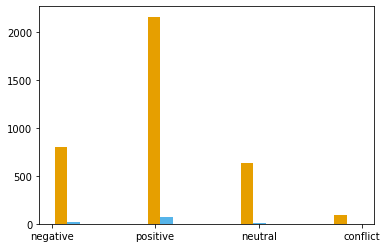

In [92]:
x1 = DF_train['polarity']
x2 = DF_test['polarity']

colors = ['#E69F00', '#56B4E9']
names = ['TRAIN', 'TEST']
         
plt.hist([x1, x2],color = colors, label=names)


#### Les nombres n'étant pas très pertinent pour étudier la répartition nous regarderons plutôt le pourcentage :

In [93]:
# NOMBRES
posTrain=len(DF_train[DF_train['polarity'] == 'positive' ].index)
negTrain=len(DF_train[DF_train['polarity'] == 'negative' ].index)
neuTrain=len(DF_train[DF_train['polarity'] == 'neutral' ].index)
confTrain=len(DF_train[DF_train['polarity'] == 'conflict' ].index)

posTest=len(DF_test[DF_test['polarity'] == 'positive' ].index)
negTest=len(DF_test[DF_test['polarity'] == 'negative' ].index)
neuTest=len(DF_test[DF_test['polarity'] == 'neutral' ].index)
confTest=len(DF_test[DF_test['polarity'] == 'conflict' ].index)

print(posTrain,negTrain,neuTrain,confTrain)
print(posTest,negTest,neuTest,confTest)

# TAUX
pos_train=len(DF_train[DF_train['polarity'] == 'positive' ].index)/len(DF_train)
neg_train=len(DF_train[DF_train['polarity'] == 'negative' ].index)/len(DF_train)
neu_train=len(DF_train[DF_train['polarity'] == 'neutral' ].index)/len(DF_train)
conf_train=len(DF_train[DF_train['polarity'] == 'conflict' ].index)/len(DF_train)

pos_test=len(DF_test[DF_test['polarity'] == 'positive' ].index)/len(DF_test)
neg_test=len(DF_test[DF_test['polarity'] == 'negative' ].index)/len(DF_test)
neu_test=len(DF_test[DF_test['polarity'] == 'neutral' ].index)/len(DF_test)
conf_test=len(DF_test[DF_test['polarity'] == 'conflict' ].index)/len(DF_test)

print(pos_train,neg_train,neu_train,conf_train)
print(pos_test,neg_test,neu_test,conf_test)


2164 805 633 91
68 18 10 0
0.5859734633089629 0.21797996209044138 0.17140536149471974 0.02464121310587598
0.7083333333333334 0.1875 0.10416666666666667 0.0


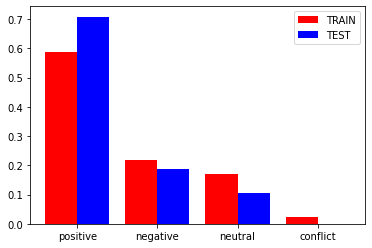

In [94]:
barWidth = 0.4
train = [pos_train, neg_train, neu_train, conf_train]
test = [pos_test, neg_test, neu_test, conf_test]
r1 = range(len(train))
r2 = [x + barWidth for x in r1]

plotTrain= plt.bar(r1, train, width = barWidth, color = ['red' for i in train])
plotTest= plt.bar(r2, test, width = barWidth, color = ['blue' for i in train])
plt.xticks([r + barWidth / 2 for r in range(len(train))], ['positive', 'negative', 'neutral','conflict'])
plt.legend([plotTrain, plotTest], ['TRAIN', 'TEST'])

**<font color="red"> Il n'y a pas de "conflict" dans l'ensemble de test, on ne prendra pas en compte ces valeurs. <font>**

**<font color="green">Les autres classes semblent bien réparties.</font>**

In [14]:
# On récupère les indexes qui contiennent des "conflicts"
indexNames = DF_train[DF_train['polarity'] == 'conflict' ].index
# on retire les lignes concernées
DF_train.drop(indexNames , inplace=True)

# On récupère les indexes qui contiennent des "conflicts"
indexNames = DF_test[DF_test['polarity'] == 'conflict' ].index
# on retire les lignes concernées
DF_test.drop(indexNames , inplace=True)

In [15]:
# On récupère les indexes qui contiennent des "conflicts"
indexNames = DF_train[DF_train['polarity'] == 'conflict' ].index

# On récupère les indexes qui contiennent des "conflicts"
indexNames = DF_test[DF_test['polarity'] == 'conflict' ].index


**vérification rapide**

In [16]:
print(len(DF_test[DF_test['polarity'] == 'conflict' ].index))
print(len(DF_test[DF_test['polarity'] == 'conflict' ].index))

print(len(DF_train[DF_train['polarity'] == 'conflict' ].index))
print(len(DF_train[DF_train['polarity'] == 'conflict' ].index))



df_train.head(3)

0
0
0
0


,index,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,0,staff,negative,8,13,3121,But the staff was so horrible to us.,"[[], [0.0, 0.0, 1.0], [0.0, 0.625, 0.375], [],...","[CCONJ, DET, NOUN, AUX, ADV, ADJ, ADP, PRON, P...","[But, staff, horrible, us, .]","(But, the, staff, was, so, horrible, to, us, .)"
1,1,food,positive,57,61,2777,"To be completely fair, the only redeeming fact...","[[], [0.5, 0.0, 0.5], [0.625, 0.0, 0.375], [],...","[PART, AUX, ADV, ADJ, PUNCT, DET, ADJ, VERB, N...","[To, completely, fair, ,, redeeming, factor, f...","(To, be, completely, fair, ,, the, only, redee..."
2,2,food,positive,4,8,1634,"The food is uniformly exceptional, with a very...","[[], [0.0, 0.0, 1.0], [], [], [], [0.125, 0.0,...","[DET, NOUN, AUX, ADV, ADJ, PUNCT, ADP, DET, AD...","[The, food, uniformly, exceptional, ,, capable...","(The, food, is, uniformly, exceptional, ,, wit..."


In [2]:
# sauvegarder en Dataframe grace à .pkl
#DF_train.to_pickle('DF_train_PANDAS_DATAFRAME.pkl')  
#DF_test.to_pickle('DF_test_PANDAS_DATAFRAME.pkl')  
#Pour recharger les dataframe : 
DF_train = pd.read_pickle('DF_train_PANDAS_DATAFRAME.pkl')
DF_test = pd.read_pickle('DF_test_PANDAS_DATAFRAME.pkl')

In [3]:
DF_train.reset_index(inplace=True, drop=False)
DF_test.reset_index(inplace=True, drop=False)
DF_train[25:33]

,index,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
25,25,pizza,positive,4,9,3359,The pizza is the best if you like thin crusted...,"[[], [0.0, 0.0, 1.0], [0.75, 0.0, 0.25], [], [...","[DET, NOUN, AUX, DET, ADJ, SCONJ, PRON, SCONJ,...","[The, pizza, best, like, thin, crusted, pizza, .]","(The, pizza, is, the, best, if, you, like, thi..."
26,26,thin crusted pizza,neutral,34,52,3359,The pizza is the best if you like thin crusted...,"[[], [0.0, 0.0, 1.0], [0.75, 0.0, 0.25], [], [...","[DET, NOUN, AUX, DET, ADJ, SCONJ, PRON, SCONJ,...","[The, pizza, best, like, thin, crusted, pizza, .]","(The, pizza, is, the, best, if, you, like, thi..."
27,27,interior decoration,positive,28,47,3534,All the money went into the interior decoratio...,"[[], [0.0, 0.0, 1.0], [], [0.375, 0.0, 0.625],...","[DET, DET, NOUN, VERB, ADP, DET, ADJ, NOUN, PU...","[All, money, went, interior, decoration, ,, no...","(All, the, money, went, into, the, interior, d..."
28,28,chefs,negative,72,77,3534,All the money went into the interior decoratio...,"[[], [0.0, 0.0, 1.0], [], [0.375, 0.0, 0.625],...","[DET, DET, NOUN, VERB, ADP, DET, ADJ, NOUN, PU...","[All, money, went, interior, decoration, ,, no...","(All, the, money, went, into, the, interior, d..."
29,29,seats,negative,4,9,1407,The seats are uncomfortable if you are sitting...,"[[], [0.0, 0.0, 1.0], [0.0, 0.75, 0.25], [], [...","[DET, NOUN, AUX, ADJ, SCONJ, PRON, AUX, VERB, ...","[The, seats, uncomfortable, sitting, wall, woo...","(The, seats, are, uncomfortable, if, you, are,..."
30,30,seltzer with lime,neutral,12,29,565,"I asked for seltzer with lime, no ice.","[[], [], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [],...","[PRON, VERB, ADP, NOUN, ADP, NOUN, PUNCT, DET,...","[I, asked, seltzer, lime, ,, ice, .]","(I, asked, for, seltzer, with, lime, ,, no, ic..."
31,31,pickles,positive,77,84,675,Don't go alone---even two people isn't enough ...,"[[], [], [], [0.25, 0.25, 0.5], [], [], [], [0...","[AUX, PART, VERB, ADV, PUNCT, ADV, NUM, NOUN, ...","[Do, n't, go, alone, --, -even, two, people, n...","(Do, n't, go, alone, ---, even, two, people, i..."
32,32,selection of meats and seafoods,positive,91,122,675,Don't go alone---even two people isn't enough ...,"[[], [], [], [0.25, 0.25, 0.5], [], [], [], [0...","[AUX, PART, VERB, ADV, PUNCT, ADV, NUM, NOUN, ...","[Do, n't, go, alone, --, -even, two, people, n...","(Do, n't, go, alone, ---, even, two, people, i..."


In [4]:
DF_train.head(3)

,index,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,0,staff,negative,8,13,3121,But the staff was so horrible to us.,"[[], [0.0, 0.0, 1.0], [0.0, 0.625, 0.375], [],...","[CCONJ, DET, NOUN, AUX, ADV, ADJ, ADP, PRON, P...","[But, staff, horrible, us, .]","(But, the, staff, was, so, horrible, to, us, .)"
1,1,food,positive,57,61,2777,"To be completely fair, the only redeeming fact...","[[], [0.5, 0.0, 0.5], [0.625, 0.0, 0.375], [],...","[PART, AUX, ADV, ADJ, PUNCT, DET, ADJ, VERB, N...","[To, completely, fair, ,, redeeming, factor, f...","(To, be, completely, fair, ,, the, only, redee..."
2,2,food,positive,4,8,1634,"The food is uniformly exceptional, with a very...","[[], [0.0, 0.0, 1.0], [], [], [], [0.125, 0.0,...","[DET, NOUN, AUX, ADV, ADJ, PUNCT, ADP, DET, AD...","[The, food, uniformly, exceptional, ,, capable...","(The, food, is, uniformly, exceptional, ,, wit..."


In [5]:
DF_test.head(3)

,index,term,polarity,from,to,id,text,Score_by_word,PosTag,Sentiword,token_text
0,0,appetizers,positive,8,18,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...","[DET, DET, NOUN, CCONJ, NOUN, AUX, ADJ, PUNCT,...","[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."
1,1,salads,positive,23,29,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...","[DET, DET, NOUN, CCONJ, NOUN, AUX, ADJ, PUNCT,...","[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."
2,2,steak,positive,49,54,813,"All the appetizers and salads were fabulous, t...","[[], [0.0, 0.0, 1.0], [], [0.875, 0.125, 0.0],...","[DET, DET, NOUN, CCONJ, NOUN, AUX, ADJ, PUNCT,...","[All, appetizers, salads, fabulous, ,, steak, ...","(All, the, appetizers, and, salads, were, fabu..."


In [6]:
# TRAIN DATASET
df_train = DF_train

list_train = []
label_train = []

for i in range(len(df_train)):
    pos_tag = [X.pos_ for X in  df_train.token_text[i]]
    pos_tag_text = " ".join(pos_tag)
    senti_word = " ".join(df_train.Sentiword[i])
    score_by_word = ",".join(str(v) for v in df_train.Score_by_word[i])
    
    list_train.append(
        (df_train.term[i],
        df_train.text[i],
        pos_tag_text,
        senti_word,
        score_by_word,
        ))
    label_train.append(df_train.polarity[i])

list_train

import numpy as np
Restaurant_Train = np.array(list_train)
print(Restaurant_Train)
#print(label_train)

[['staff' 'But the staff was so horrible to us.'
  'CCONJ DET NOUN AUX ADV ADJ ADP PRON PUNCT' 'But staff horrible us .'
  '[],[0.0, 0.0, 1.0],[0.0, 0.625, 0.375],[],[]']
 ['food'
  "To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora."
  'PART AUX ADV ADJ PUNCT DET ADJ VERB NOUN AUX DET NOUN PUNCT DET AUX ADP ADJ PUNCT CCONJ VERB PART VERB ADP ADP DET DET ADJ NOUN ADP PROPN PUNCT'
  "To completely fair , redeeming factor food , average , could n't make deficiencies Teodora ."
  '[],[0.5, 0.0, 0.5],[0.625, 0.0, 0.375],[],[],[0.0, 0.0, 1.0],[0.0, 0.0, 1.0],[],[0.0, 0.0, 1.0],[],[],[],[],[0.125, 0.125, 0.75],[],[]']
 ['food'
  "The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not."
  'DET NOUN AUX ADV ADJ PUNCT ADP DET ADV ADJ NOUN DET VERB ADV VERB ADP DET PRON VERB SCONJ VERB PUNCT SCONJ PR

In [7]:
# TEST DATASET
df_test = DF_test

list_test = []
label_test = []

for i in range(len(df_test)):
    pos_tag = [X.pos_ for X in  df_test.token_text[i]]
    pos_tag_text = " ".join(pos_tag)
    senti_word = " ".join(df_test.Sentiword[i])
    score_by_word = ",".join(str(v) for v in df_test.Score_by_word[i])
    
    list_test.append(
        (df_test.term[i],
        df_test.text[i],
        pos_tag_text,
        senti_word,
        score_by_word,
        ))
    label_test.append(df_test.polarity[i])


import numpy as np
Restaurant_Test = np.array(list_test)
print(Restaurant_Test)
#print(label_test)

[['appetizers'
  'All the appetizers and salads were fabulous, the steak was mouth watering and the pasta was delicious!!!'
  'DET DET NOUN CCONJ NOUN AUX ADJ PUNCT DET NOUN AUX NOUN VERB CCONJ DET NOUN AUX ADJ PUNCT PUNCT PUNCT'
  'All appetizers salads fabulous , steak mouth watering pasta delicious ! ! !'
  '[],[0.0, 0.0, 1.0],[],[0.875, 0.125, 0.0],[],[],[0.0, 0.0, 1.0],[],[0.0, 0.0, 1.0],[0.75, 0.0, 0.25],[],[],[]']
 ['salads'
  'All the appetizers and salads were fabulous, the steak was mouth watering and the pasta was delicious!!!'
  'DET DET NOUN CCONJ NOUN AUX ADJ PUNCT DET NOUN AUX NOUN VERB CCONJ DET NOUN AUX ADJ PUNCT PUNCT PUNCT'
  'All appetizers salads fabulous , steak mouth watering pasta delicious ! ! !'
  '[],[0.0, 0.0, 1.0],[],[0.875, 0.125, 0.0],[],[],[0.0, 0.0, 1.0],[],[0.0, 0.0, 1.0],[0.75, 0.0, 0.25],[],[],[]']
 ['steak'
  'All the appetizers and salads were fabulous, the steak was mouth watering and the pasta was delicious!!!'
  'DET DET NOUN CCONJ NOUN AUX ADJ 

### Vectorisation — TF/IDF

* Aux fins de la plupart des modélisations mathématiques effectuées sur le texte et aux fins de cette expérimentation, différents processus de « vectorisation » ont été mis en oeuvre.

* Le contenu textuel seul ne peut pas être modifié et contraint dans l'espace mathématique sans être transformé en nombres dans le but d'être lu par un algorithme d'apprentissage automatique.

* C'est pourquoi pour les besoins des méthodes supervisées dans ce projet, différents types de vectorisation ont été utilisés pour convertir des données qualitatives en données quantitatives afin de les manipuler mathématiquement. Ces vecteurs deviennent des caractéristiques intégrées pour les modèles. 

**Fréquence de terme/Fréquence de document inverse (TF/IDF)**

Il s'agit de la technique de vectorisation utilisée pour le modèle Support Vector Machine. 
* TF/IDF a été déployé sur les données d'entraînement avec une approche unigramme qui compte chaque mot individuel comme un terme. La « fréquence des termes » correspond à la fréquence à laquelle un certain mot apparaît dans le texte, la « fréquence inverse du document » fait référence à la réduction de la signification des mots qui apparaissent le plus souvent dans tout le texte.
* Cela sert à faire des mots que l'on voit fréquemment dans un document donné mais pas nécessairement dans tous les documents. 

## SVM 

### Premier test avec seulement la colonne text comme variable explicative

Ce premier test ne signifie pas grand chose, mais il permet de montrer l'efficacité de SVM. Il doit prédire sans savoir le term à analyser, et donc sans savoir pourquoi la même phrase peut avoir une polarité positive et parfois négative.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

train_vectors = vectorizer.fit_transform(DF_train['text'])
test_vectors = vectorizer.transform(DF_test['text'])

import time
from sklearn import svm
from sklearn.metrics import classification_report

# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
t0 = time.time()
classifier_linear.fit(train_vectors, DF_train['polarity'])
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(DF_test['polarity'], prediction_linear, output_dict=True)


print('positive: ', report['positive'])
print('negative: ', report['negative'])
print('neutral: ', report['neutral'])


Training time: 1.711815s; Prediction time: 0.039871s
positive:  {'precision': 0.868421052631579, 'recall': 0.9705882352941176, 'f1-score': 0.9166666666666667, 'support': 68}
negative:  {'precision': 0.875, 'recall': 0.7777777777777778, 'f1-score': 0.823529411764706, 'support': 18}
neutral:  {'precision': 0.75, 'recall': 0.3, 'f1-score': 0.4285714285714285, 'support': 10}


Les résultats sont très intéressants malgré qu'ils ne soient pas interprétable. 
<font color='red'> Cependant ce n'est pas ce que nous cherchons. Là, notre modèle prédit positif ou négatif sans savoir le term dont il s'agit. Il n'a que les phrases pour prédire. <font>

### On doit d'abord normaliser les dimensions de nos listes. De sorte que la liste ait toujours le même nombre de features. 

In [8]:
L = len(Restaurant_Test)
X_test = []
y_test = []
for i in range(0,L):
    X_test.append(Restaurant_Test[i][0] + " " + Restaurant_Test[i][1] + " " + Restaurant_Test[i][2] + " " + Restaurant_Test[i][3]+ " " + Restaurant_Test[i][4])
    y_test.append(label_test[i])

X_test[0:3]

['appetizers All the appetizers and salads were fabulous, the steak was mouth watering and the pasta was delicious!!! DET DET NOUN CCONJ NOUN AUX ADJ PUNCT DET NOUN AUX NOUN VERB CCONJ DET NOUN AUX ADJ PUNCT PUNCT PUNCT All appetizers salads fabulous , steak mouth watering pasta delicious ! ! ! [],[0.0, 0.0, 1.0],[],[0.875, 0.125, 0.0],[],[],[0.0, 0.0, 1.0],[],[0.0, 0.0, 1.0],[0.75, 0.0, 0.25],[],[],[]',
 'salads All the appetizers and salads were fabulous, the steak was mouth watering and the pasta was delicious!!! DET DET NOUN CCONJ NOUN AUX ADJ PUNCT DET NOUN AUX NOUN VERB CCONJ DET NOUN AUX ADJ PUNCT PUNCT PUNCT All appetizers salads fabulous , steak mouth watering pasta delicious ! ! ! [],[0.0, 0.0, 1.0],[],[0.875, 0.125, 0.0],[],[],[0.0, 0.0, 1.0],[],[0.0, 0.0, 1.0],[0.75, 0.0, 0.25],[],[],[]',
 'steak All the appetizers and salads were fabulous, the steak was mouth watering and the pasta was delicious!!! DET DET NOUN CCONJ NOUN AUX ADJ PUNCT DET NOUN AUX NOUN VERB CCONJ DET NOUN

In [9]:
L = len(Restaurant_Train)
X_train = []
y_train = []
for i in range(0,L):
    X_train.append(Restaurant_Train[i][0] + " " + Restaurant_Train[i][1] + " " + Restaurant_Train[i][2] + " " + Restaurant_Train[i][3]+ " " + Restaurant_Train[i][4])
    y_train.append(label_train[i])

X_train[0:3]

['staff But the staff was so horrible to us. CCONJ DET NOUN AUX ADV ADJ ADP PRON PUNCT But staff horrible us . [],[0.0, 0.0, 1.0],[0.0, 0.625, 0.375],[],[]',
 "food To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora. PART AUX ADV ADJ PUNCT DET ADJ VERB NOUN AUX DET NOUN PUNCT DET AUX ADP ADJ PUNCT CCONJ VERB PART VERB ADP ADP DET DET ADJ NOUN ADP PROPN PUNCT To completely fair , redeeming factor food , average , could n't make deficiencies Teodora . [],[0.5, 0.0, 0.5],[0.625, 0.0, 0.375],[],[],[0.0, 0.0, 1.0],[0.0, 0.0, 1.0],[],[0.0, 0.0, 1.0],[],[],[],[],[0.125, 0.125, 0.75],[],[]",
 "food The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not. DET NOUN AUX ADV ADJ PUNCT ADP DET ADV ADJ NOUN DET VERB ADV VERB ADP DET PRON VERB SCONJ VERB PUNCT SCONJ PRON AUX ADP DET NOUN CCONJ PART PUNCT Th

### Vectorisation avec TfidfTransformer

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import time
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Create feature vectors
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)

X_train_tf = tf_transformer.transform(X_train_counts)

X_test_counts = count_vect.transform(X_test)
X_test_tf = tf_transformer.transform(X_test_counts)

print(X_train_counts.shape)
print(X_train_tf.shape)

print(X_test_counts.shape)
print(X_test_tf.shape)



(3693, 3784)
(3693, 3784)
(96, 3784)
(96, 3784)


On voit que le nombre de features est toujours le même.

In [11]:
# Test avec kernel=rbf
classifier_linear = svm.SVC(kernel='rbf')
t0 = time.time()
classifier_linear.fit(X_train_tf, y_train)
t1 = time.time()
prediction_linear = classifier_linear.predict(X_test_tf)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, output_dict=True)
print("Accuracy total score :", accuracy_score(y_test, prediction_linear))


print('positive: ', report['positive'])
print('negative: ', report['negative'])
print('neutral: ', report['neutral'])
print('------ REPORT ------')
report

Training time: 2.980229s; Prediction time: 0.061034s
Accuracy total score : 0.8958333333333334
positive:  {'precision': 0.881578947368421, 'recall': 0.9852941176470589, 'f1-score': 0.9305555555555556, 'support': 68}
negative:  {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 18}
neutral:  {'precision': 0.875, 'recall': 0.7, 'f1-score': 0.7777777777777777, 'support': 10}
------ REPORT ------


{'negative': {'precision': 1.0,
  'recall': 0.6666666666666666,
  'f1-score': 0.8,
  'support': 18},
 'neutral': {'precision': 0.875,
  'recall': 0.7,
  'f1-score': 0.7777777777777777,
  'support': 10},
 'positive': {'precision': 0.881578947368421,
  'recall': 0.9852941176470589,
  'f1-score': 0.9305555555555556,
  'support': 68},
 'accuracy': 0.8958333333333334,
 'macro avg': {'precision': 0.918859649122807,
  'recall': 0.7839869281045752,
  'f1-score': 0.8361111111111111,
  'support': 96},
 'weighted avg': {'precision': 0.9030975877192983,
  'recall': 0.8958333333333334,
  'f1-score': 0.890162037037037,
  'support': 96}}

Les résultats sont déjà très bon, avec une précision de 0.88 pour les **positif**, 1.0 pour les **negatif** et 0.87 pour les **neutre**.

In [12]:
# Test avec kernel=poly
classifier_linear = svm.SVC(kernel='poly')
t0 = time.time()
classifier_linear.fit(X_train_tf, y_train)
t1 = time.time()
prediction_linear = classifier_linear.predict(X_test_tf)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, output_dict=True)
print("Accuracy total score :", accuracy_score(y_test, prediction_linear))

print('positive: ', report['positive'])
print('negative: ', report['negative'])
print('neutral: ', report['neutral'])
print('------ REPORT ------')
report

Training time: 3.609570s; Prediction time: 0.079969s
Accuracy total score : 0.90625
positive:  {'precision': 0.8933333333333333, 'recall': 0.9852941176470589, 'f1-score': 0.9370629370629371, 'support': 68}
negative:  {'precision': 1.0, 'recall': 0.6666666666666666, 'f1-score': 0.8, 'support': 18}
neutral:  {'precision': 0.8888888888888888, 'recall': 0.8, 'f1-score': 0.8421052631578948, 'support': 10}
------ REPORT ------


{'negative': {'precision': 1.0,
  'recall': 0.6666666666666666,
  'f1-score': 0.8,
  'support': 18},
 'neutral': {'precision': 0.8888888888888888,
  'recall': 0.8,
  'f1-score': 0.8421052631578948,
  'support': 10},
 'positive': {'precision': 0.8933333333333333,
  'recall': 0.9852941176470589,
  'f1-score': 0.9370629370629371,
  'support': 68},
 'accuracy': 0.90625,
 'macro avg': {'precision': 0.9274074074074073,
  'recall': 0.8173202614379086,
  'f1-score': 0.859722733406944,
  'support': 96},
 'weighted avg': {'precision': 0.9128703703703703,
  'recall': 0.90625,
  'f1-score': 0.9014722119985278,
  'support': 96}}

Après avoir testé des kernels sigmoid et linéaire également, le noyau Polynomial semble donner de meilleur résultat que ceux-ci, ainsi que le RBF précédemment, notamment pour les positifs et les neutres. 
Je garde donc cette typologie avec le kernel POLY.

# Petit plus 
------------------------------------------------------------------- 

### NEURAL NETWORK : FULLY CONNECTED LAYERS MODEL

In [25]:
# import the necessary packages
from keras.models import Sequential
from keras.layers import Dense

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_len = 200

# --------- TRAIN ------------ #
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
X_train_vect = pad_sequences(sequences_train,maxlen=max_len)
print(X_train_vect)
print(X_train_vect.shape)

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y_train = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)
print(encoded_Y_train.shape)
print(dummy_y_train.shape)

# --------- TEST ------------ #

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_test)
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test_vect = pad_sequences(sequences_test,maxlen=max_len)
print(X_test_vect)
print(X_test_vect.shape)


encoder.fit(y_test)
encoded_Y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
print(encoded_Y_test.shape)
print(dummy_y_test.shape)



[[ 0  0  0 ... 19  1 20]
 [ 0  0  0 ... 18  1 22]
 [ 0  0  0 ...  1  2  1]
 ...
 [ 0  0  0 ...  1  2  1]
 [ 0  0  0 ...  1  2  1]
 [ 0  0  0 ...  1  2  1]]
(3602, 200)
(3602,)
(3602, 3)
[[ 0  0  0 ...  1  1  9]
 [ 0  0  0 ...  1  1  9]
 [ 0  0  0 ...  1  1  9]
 ...
 [ 0  0  0 ...  1  2  1]
 [ 0  0  0 ...  1  2  1]
 [ 0  0  0 ...  1  1 25]]
(96, 200)
(96,)
(96, 3)


In [27]:
# define the keras model
model = Sequential()
model.add(Dense(200, input_dim=200, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
model.fit(X_train_vect, dummy_y_train, epochs=150, batch_size=10)

# evaluate the keras model
loss, accuracy = model.evaluate(X_train_vect, dummy_y_train)
print('Accuracy: %.2f' % (accuracy*100))
print('Loss : %.2f' % loss)

model.evaluate(X_train_vect,dummy_y_train)

Epoch 1/150
361/361 [==============================] - 1s 1ms/step - loss: 59.8798 - accuracy: 0.4806
Epoch 2/150
361/361 [==============================] - 0s 1ms/step - loss: 15.1388 - accuracy: 0.6080
Epoch 3/150
361/361 [==============================] - 0s 1ms/step - loss: 7.6212 - accuracy: 0.6696
Epoch 4/150
361/361 [==============================] - 1s 2ms/step - loss: 4.7777 - accuracy: 0.7121
Epoch 5/150
361/361 [==============================] - 1s 1ms/step - loss: 3.2773 - accuracy: 0.7479
Epoch 6/150
361/361 [==============================] - 0s 1ms/step - loss: 2.3684 - accuracy: 0.7662
Epoch 7/150
361/361 [==============================] - 0s 1ms/step - loss: 1.5720 - accuracy: 0.7873
Epoch 8/150
361/361 [==============================] - 0s 1ms/step - loss: 1.1618 - accuracy: 0.8071
Epoch 9/150
361/361 [==============================] - 0s 1ms/step - loss: 0.8651 - accuracy: 0.8257
Epoch 10/150
361/361 [==============================] - 0s 1ms/step - loss: 0.7994 - accu

[0.46017691493034363, 0.737090528011322]